## kaggle 신용 카드 사기 감지
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- https://www.kaggle.com/code/ysjang0926/kor-introduction-to-anomaly-detection-r01/notebook
- https://alpaca-gt.tistory.com/379

#### 1. Data load

In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Time : 이 트랜잭션과 데이터세트의 첫 번째 트랜잭션 사이에 경과된 시간(초)
- v1 ~ v28 : 사용자 ID 및 민감한 기능을 보호하기 위한 PCA 차원 축소(v1-v28)의 결과
- Amount : 거래 금액
- Class : Target 변수(0: 정상, 1: 비정상)
    - 총 284,807건의 거래내역이 제공
    - 사기 거래(Fraud Transaction)는 492건

In [2]:
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24) # 비율
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


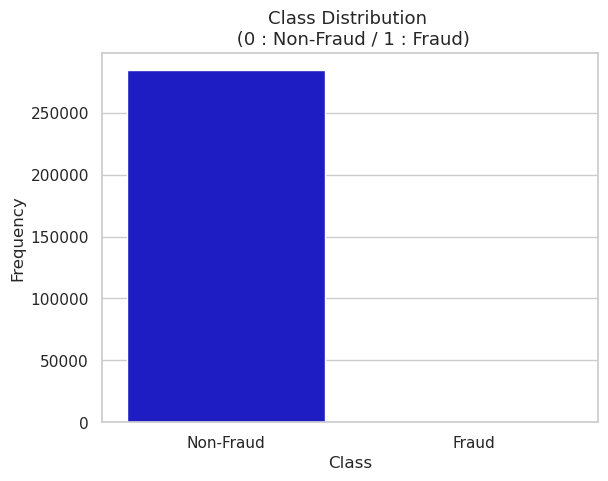

In [3]:
colors = ["#0101DF", "#DF0101"]
LABELS = ["Non-Fraud", "Fraud"]

sns.countplot('Class', data=data, palette=colors)
plt.title('Class Distribution \n (0 : Non-Fraud / 1 : Fraud)', fontsize=13)
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [4]:
vc = data['Class'].value_counts().to_frame().reset_index()

vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))

vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [5]:
data.isnull().sum().max()

0

- 분포

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 23.999444444444446)

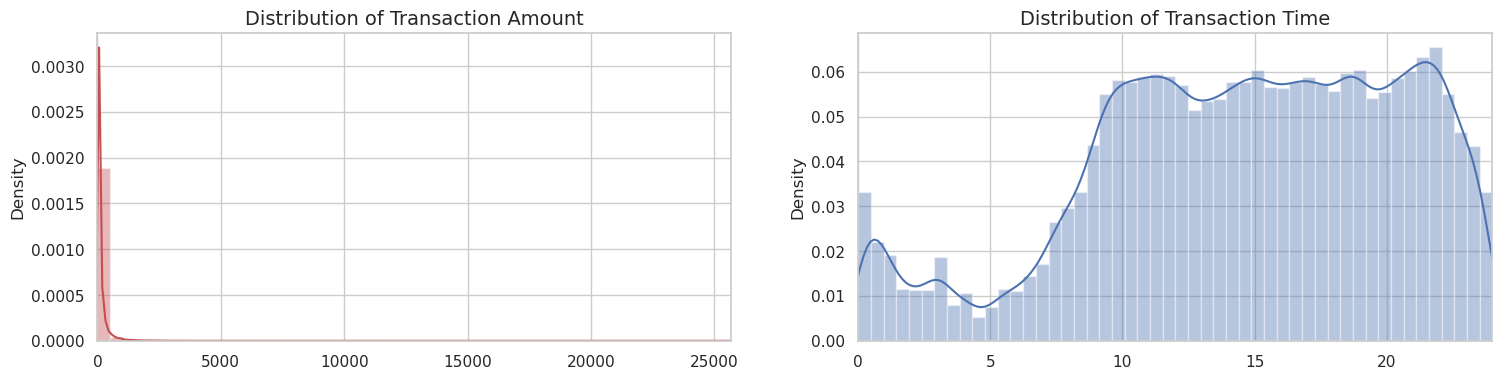

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

#### 2. 데이터 전처리

- 가장 큰 문제 중 하나는 사기 거래가 0.17%에 불과하기 때문에 대상의 불균형이 매우 크다는 점
- non-fraud 거래내역의 1,000행만 사용

In [7]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

/tmp/ipykernel_5594/3091554375.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


In [8]:
X

array([[ 1.24783333e+01, -4.69678467e-01,  6.64138028e-01, ...,
        -2.90249217e-01, -3.29506840e-01,  2.53920000e+02],
       [ 1.75263889e+01,  9.70481912e-01, -8.47492750e-01, ...,
         6.04162068e-02,  4.25376526e-02,  1.45420000e+02],
       [ 1.46436111e+01, -3.97593926e+00, -1.24493887e+00, ...,
         8.77423851e-01,  6.67568430e-01,  8.30000000e+00],
       ...,
       [ 1.48291667e+01,  1.23781545e+00, -9.35982632e-01, ...,
         3.55347752e-02,  1.36201938e-02,  2.99500000e+01],
       [ 2.30419444e+01, -6.76142671e-01,  1.12636606e+00, ...,
         3.85107449e-01,  1.94361479e-01,  7.78900000e+01],
       [ 1.30361111e+01,  2.09212691e+00, -1.22863088e-02, ...,
        -1.50543753e-01, -1.00051523e-01,  1.00000000e+01]])

In [9]:
Y

array([0, 0, 1, ..., 0, 1, 0])

#### 3. 시각화

- t-SNE(t-Distributed Stochastic Neighbor Embedding)란?
    - 높은 차원의 복잡한 데이터를 2차원에 차원 축소하는 방법
    - 고차원 데이터의 시각화에 용이하게 사용되며 차원 축소할 때는 비슷한 구조끼리 데이터를 정리한 상태이므로 데이터 구조를 이해
    - 고차원 공간에서의 각 데이터 포인트 주변으로 유사도를 계산하여, 각 데이터 포인트를 2차원에서 원본 특성 공간에서 비슷한 데이터 구조는 가깝게 비슷하지 않은 데이터 구조는 멀리 떨어지게 만드며, 즉 이웃 데이터 포인트에 대한 정보를 보존하려고 노력

- PCA와 차이점
    - PCA는 linear한 방법을 사용하지만, t-SNE는 비선형적인 방법의 차원축소 방법
    - PCA : 공분산 행렬에서 고유벡터를 계산
    - t-SNE : 고차원 공간에서의 점들의 유사성과 그에 해당하는 저차원 공간에서의 점들의 유사성을 계산
    - t-SNE는 input feature를 확인하기 어렵기 때문에 t-SNE 결과만 가지고 무언가를 추론하기 어려움 (t-SNE는 주로 시각화 툴로 사용)

- t-SNE 구하는 방법
    - 각 데이터 포인트 주변으로 유사도를 구해 클러스터를 만듦
    - 관심 데이터 포인트를 하나 잡고, 그 값을 평균으로 갖는 정규분포그래프를 그림
        - → 주변의 데이터의 경우(같은 클러스터) 유사도가 높게 나오고,(정규분포의 확률값) 먼 데이터는 유사도가 낮음
    - 모든 데이터 포인트에 대한 유사도를 그려, 상관계수그래프처럼 나열함
        - → 같은 클러스터는 높은 유사도를 지님
    - 임의로 낮은 차원으로 데이터 포인트를 사영시키고, 데이터마다 유사도를 계산함.(정규분포로 했듯이)
    - t분포를 대신 사용하는데, 그래서 t-sne임
        - t-분포를 사용하는 이유는, 클러스터들을 좀더 성기게 분포시키기 위함

In [10]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.show();

- 모든 점은 거래(transaction)를 나타내며, Non-Fraud(비사기) 거래는 녹색으로 표시되고 Fraud(사기) 거래는 빨간색으로 표시
- 두 축은 tsne에 의해 추출된 성분

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


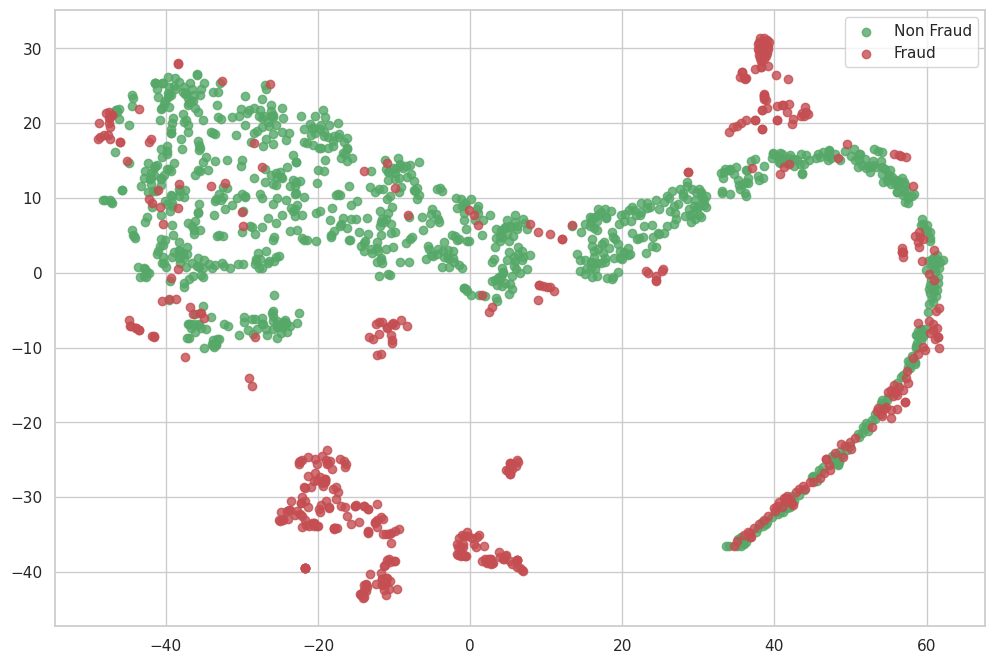

In [11]:
tsne_plot(X, Y, "original.png")

#### 4. AutoEncoders 

- Autoencoder는 출력이 입력과 동일한 특수한 유형의 신경망(neural network) 아키텍처
- 입력 데이터의 극히 낮은 level을 학습하기 위해 unsupervised 방식으로 훈련되며, 그런 다음 이러한 낮은 level의 기능은 실제 데이터를 투영하기 위해 다시 변형
- 입력을 그대로 출력(복원)해내도록 하는 목적 함수를 갖는 항등 함수(identity function) 모델링
    - 입력된 데이터의 특성을 요약하는 Encoder(인코더)
    - 요약된 정보를 복원하는 Decoder(디코더)
    - => 입력값을 답으로 주기 때문에 스스로 학습을 한다고 해서 자기지도학습

- 가정 : 정상 관측치들은 불량 관측치보다 더 잘 복원될 것
- 차원이 축소되는 부분을 Bottlenect(잠재벡터)이라고 하며, Autoencoder는 z 부분을 효과적으로 학습하는 것이 목적

- MSE 손실 함수를 사용하며, 중간에 위치한 몇 개의 뉴런의 병목(bottle-neck) 현상이 심하여 Decoder에서 원래 입력을 재생산하는 데 사용할 수 있는 저차원 코드로 입력을 압축하는 효과적인 표현을 생성해야함
- 고차원 공간 상의 입력 데이터를 저차원의 공간으로 맵핑(mapping)하여 잠재적인 변수로 표현(latent representation)하였다가, 다시 입력과 같은 고차원의 공간으로 복원해야 함
- 데이터가 잘 복원된 경우 저차원의 데이터 특성 공간을 잘 파악했다고 볼 수 있음

- ===> Autoencoder는 입력 데이터와 복원된 데이터 사이의 차이(재구축 오차, Reconstruction Error)를 계산하여 이상치를 탐지

1) Autoencoder는 어떤 데이터의 입력을 받은 후, 정보를 압축시켰다가 다시 확장하며 입력받은 것과 최대한 비슷한 결과값을 반환하는 '재구성'의 방법을 통해 특정 데이터의 패턴을 인코딩함
2) 신용카드 거래 데이터셋은 대부분 정상 거래 데이터로 이루어져 있으며, 이상 거래 데이터는 적게 포함되어 있는 불균형한 데이터셋임
3) Autoencoder 모델을 정상 거래 데이터만으로 학습시키면 이상 거래 데이터가 입력으로 주어지는 경우에는 재구성이 잘 안 되는데, 이 원리를 활용해 신용카드 이상 거래를 탐지함

In [12]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

2022-11-02 10:57:59.447006: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 10:57:59.450861: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


- Network의 구조(뉴런수)는 input → 100 → 50 → 50 → 100 → input으로, 가운데(Bottle-neck Layer) Dimension이 50임
- 시각화하는 과정에서 이를 다시 2차원으로 t-SNE를 활용하여 축소하고 시각화함

In [13]:
autoencoder = Model(input_layer, output_layer)

# adadelta : Adagrad, RMSprop, Momentum 모두를 합친 경사하강법
# Adadelta는 과거의 모든 그래디언트를 누적하는 대신 그래디언트 업데이트의 이동 창을 기반으로 학습률을 조정
autoencoder.compile(optimizer="adadelta", loss="mse")

- 각 변수의 범위가 다르기 때문에 Min-Max scaling을 통해 수준을 맞춰주는 작업을 수행

In [14]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

- 모델 훈련

In [15]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 1s 50ms/step - loss: 0.2128 - val_loss: 0.2123
Epoch 2/10
7/7 [==============================] - 0s 25ms/step - loss: 0.2123 - val_loss: 0.2119
Epoch 3/10
7/7 [==============================] - 0s 33ms/step - loss: 0.2119 - val_loss: 0.2115
Epoch 4/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2114 - val_loss: 0.2110
Epoch 5/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2110 - val_loss: 0.2106
Epoch 6/10
7/7 [==============================] - 0s 33ms/step - loss: 0.2105 - val_loss: 0.2101
Epoch 7/10
7/7 [==============================] - 0s 19ms/step - loss: 0.2101 - val_loss: 0.2097
Epoch 8/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2096 - val_loss: 0.2092
Epoch 9/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2092 - val_loss: 0.2088
Epoch 10/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2087 - val_loss: 0.2083


- sequential layers을 포함하는 또 다른 네트워크를 만들고, 잠재적인 변수로의 표현(latent representation)이 존재하는 세 번째 layer까지만 훈련된 가중치를 추가

In [16]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

- raw inputs을 예측하여 사기(Fraud)와 비사기(Non-Fraud)라는 두 가지 클래스에 대한 숨겨진 표현을 생성

In [17]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

- 사기(Fraud)와 비사기(Non-Fraud) 거래가 가시적(visible)이고 선형적으로(linearly) 분리할 수 있음을 알 수 있음

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


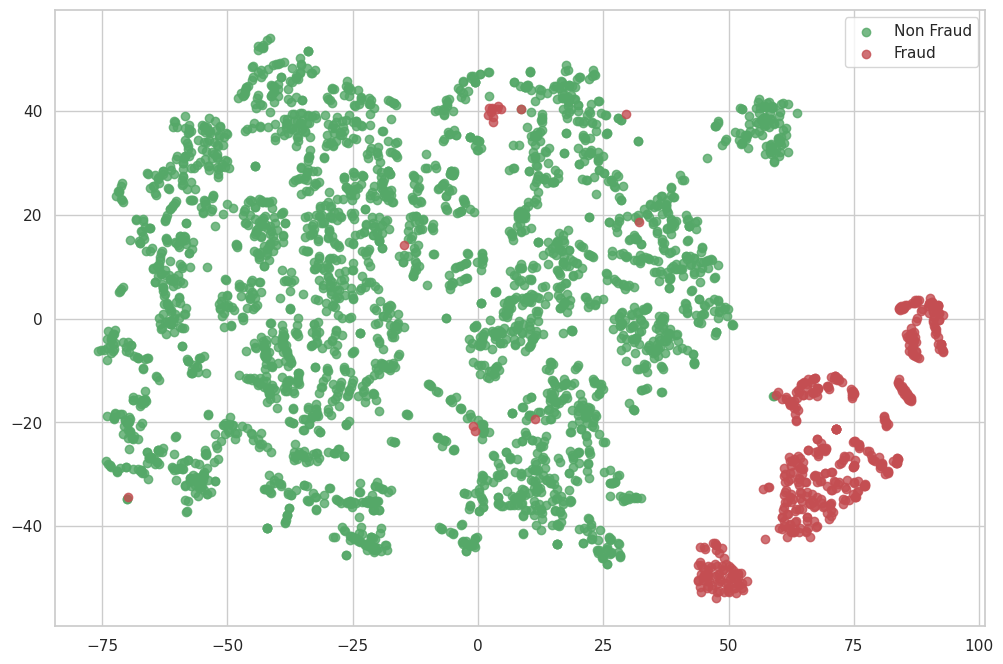

In [19]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)

y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])

rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

#### 5. Simple Linear Classifier 

In [20]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)

pred_y = clf.predict(val_x)

In [21]:
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print('Logistic Regression Accuracy Score: ', round(accuracy_score(val_y, pred_y) * 100, 3).astype(str) + '%')

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       1.00      0.88      0.93       131

    accuracy                           0.98       873
   macro avg       0.99      0.94      0.96       873
weighted avg       0.98      0.98      0.98       873


Logistic Regression Accuracy Score:  98.167%


- 총 873건의 Test Set 중 Non-Fraud는 742건 & Fraud는 114건
- Fraud는 129건 중 114건은 맞추고 16건은 틀린 것을 확인

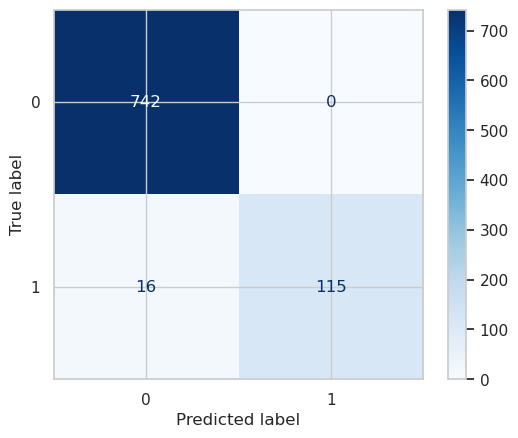

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred=pred_y, y_true=val_y)
cmp = ConfusionMatrixDisplay(cm)

cmp.plot(cmap=plt.cm.Blues)